<a href="https://colab.research.google.com/github/Souvik-kundu-off/SCT_ML_3/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install kaggle

In [ ]:
import kagglehub
path = kagglehub.dataset_download("salader/dogs-vs-cats")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dogs-vs-cats


In [ ]:
import os
print(os.listdir(path))

['dogs_vs_cats', 'test', 'train']


In [ ]:
import os
import glob
import random

data_dir = os.path.join(path, 'train')
categories = ["cats", "dogs"]
limit_per_class = 600

image_paths = []
labels = []

for category in categories:
    category_dir = os.path.join(data_dir, category)
    if not os.path.exists(category_dir):
        print(f"Warning: Directory not found for category: {category_dir}")
        continue
    category_image_paths = glob.glob(os.path.join(category_dir, "*.jpg"))
    random.shuffle(category_image_paths)
    category_image_paths = category_image_paths[:limit_per_class]
    image_paths.extend(category_image_paths)
    labels.extend([category] * len(category_image_paths))
print(f"Loaded {len(image_paths)} images ({labels.count('cats')} cats, {labels.count('dogs')} dogs)")
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)

Loaded 1200 images (600 cats, 600 dogs)


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

IMG_WIDTH = 128
IMG_HEIGHT = 128

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = 1 if label == 'dogs' else 0
    return image, label
train_paths, test_paths, train_labels, test_labels = train_test_split(
    list(image_paths), list(labels), test_size=0.2, random_state=42
)

print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")

Training set size: 960
Testing set size: 240


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_ds = train_ds.map(lambda x, y: preprocess_image(x, y))
test_ds = test_ds.map(lambda x, y: preprocess_image(x, y))
BATCH_SIZE = 32

train_ds = train_ds.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training dataset:", train_ds)
print("Testing dataset:", test_ds)

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Testing dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
import cv2
import numpy as np

def extract_features(image_path, width, height):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image file: {image_path}")
            return None
        img_resized = cv2.resize(img, (width, height))
        features = img_resized.flatten()
        return features
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
features = []
valid_labels = []

for i, image_path in enumerate(image_paths):
    img_features = extract_features(image_path, IMG_WIDTH, IMG_HEIGHT)
    if img_features is not None:
        features.append(img_features)
        valid_labels.append(labels[i])
features_np = np.array(features)
labels = valid_labels

print(f"Shape of features array: {features_np.shape}")
print(f"Number of valid labels: {len(labels)}")

Shape of features array: (1200, 49152)
Number of valid labels: 1200


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features_np, labels, test_size=0.2, random_state=42
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of y_test: {len(y_test)}")

Shape of X_train: (960, 49152)
Shape of X_test: (240, 49152)
Length of y_train: 960
Length of y_test: 240


In [ ]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)

print("SVM model training complete.")

SVM model training complete.


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6458


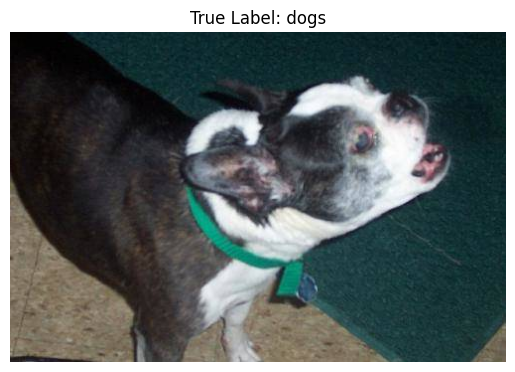

True Label: dogs
Predicted Label: cats


In [ ]:
import random
import matplotlib.pyplot as plt
import cv2

random_index = random.randint(0, len(test_paths) - 1)

selected_image_path = test_paths[random_index]
true_label = test_labels[random_index]

try:
    img = cv2.imread(selected_image_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f"True Label: {true_label}")
        plt.axis('off') # Hide axes
        plt.show()
    else:
        print(f"Could not load image for display: {selected_image_path}")
except Exception as e:
    print(f"Error displaying image {selected_image_path}: {e}")

predicted_label = y_pred[random_index]

print(f"True Label: {true_label}")
print(f"Predicted Label: {'dogs' if predicted_label == 'dogs' else 'cats'}")

In [ ]:
import gradio as gr
import numpy as np

def predict_image(image):

    if not isinstance(image, np.ndarray):

        pass
    temp_img_path = "/tmp/gradio_temp_image.png"
    try:
        if image.shape[-1] == 3:
             image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        else:
             image_bgr = image

        cv2.imwrite(temp_img_path, image_bgr)
    except Exception as e:
        return f"Error saving image for processing: {e}"


    features = extract_features(temp_img_path, IMG_WIDTH, IMG_HEIGHT)

    try:
        os.remove(temp_img_path)
    except OSError as e:
        print(f"Error removing temporary image file: {e}")


    if features is None:
        return "Error: Could not process image."
    features = features.reshape(1, -1)

    prediction = svm_model.predict(features)

    return "dog" if prediction[0] == 'dogs' else "cat"


iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs="label",
    title="Cat vs Dog Classifier",
    description="Upload an image of a cat or a dog to get a prediction."
)

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://43575eb6a8083f5ab0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://43575eb6a8083f5ab0.gradio.live
